In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import sys 
sys.path.append('/home/ubuntu/nk-paper-2024/pscapes')
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/nk-ml-2024')


import numpy as np
import itertools
from sklearn.utils import gen_batches

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
from pscapes.landscape_models import make_NK
from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array

from src.architectures.testmlp import AminoAcidMLP
from src.architectures.architectures import SequenceRegressionMLP

from src.architectures.ml_utils import train_model, train_val_test_split_ohe

## Testing MLP

In [2]:
AA_ALPHABET = 'ACDEFG'
SEQ_LENGTH  = 6
K_VALS   = list(range(SEQ_LENGTH))

In [3]:
NK_LANDSCAPES = [make_NK(SEQ_LENGTH, k, AA_ALPHABET, np.random.uniform) for k in K_VALS]

In [4]:
LANDSCAPES = [ProteinLandscape(data=dict_to_np_array(i), amino_acids=AA_ALPHABET) for i in NK_LANDSCAPES]

In [5]:
%%capture

#fit one hot
[i.fit_OHE() for i in LANDSCAPES]

In [6]:
#MLP_params
input_size = SEQ_LENGTH * len(AA_ALPHABET)  # Total input size after flattening
input_size

36

In [7]:
landscapes_ohe, xy_training, xy_val, xy_test, x_test, y_test = train_val_test_split_ohe(LANDSCAPES)

In [8]:
#instantiate models
models     = [SequenceRegressionMLP(alphabet_size=len(AA_ALPHABET), sequence_length=SEQ_LENGTH) for i in LANDSCAPES]
loss_fns   = [nn.MSELoss() for i in models]
optimizers = [optim.Adam(i.parameters(), lr=0.001) for i in models]

In [9]:
def get_trainable_params(model): 
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return pytorch_total_params

In [10]:
params = [get_trainable_params(i) for i in models]

In [11]:
params

[13057, 13057, 13057, 13057, 13057, 13057]

In [12]:

batch_size1 = 32

In [13]:
TRAIN_DATALOADER = [DataLoader(i, batch_size=batch_size1) for i in xy_training]
VAL_DATALOADER   = [DataLoader(i, batch_size=batch_size1) for i in xy_val]

In [14]:
# Start training
losses = [train_model(models[i], optimizers[i], loss_fns[i], TRAIN_DATALOADER[i], VAL_DATALOADER[i], 
                      n_epochs=30, device='cuda', patience=5, min_delta=1e-5 ) for i in range(len(models))]



Epoch [1/30], Train Loss: 1.9501, Val Loss: 0.0001
Epoch [2/30], Train Loss: 0.0314, Val Loss: 0.0000
Epoch [3/30], Train Loss: 0.0150, Val Loss: 0.0000
Epoch [4/30], Train Loss: 0.0084, Val Loss: 0.0000
Epoch [5/30], Train Loss: 0.0064, Val Loss: 0.0000
Epoch [6/30], Train Loss: 0.0054, Val Loss: 0.0000
Epoch [7/30], Train Loss: 0.0048, Val Loss: 0.0000
Epoch [8/30], Train Loss: 0.0036, Val Loss: 0.0000
Epoch [9/30], Train Loss: 0.0049, Val Loss: 0.0000
Early stopping triggered
Epoch [1/30], Train Loss: 5.9681, Val Loss: 0.0007
Epoch [2/30], Train Loss: 0.5277, Val Loss: 0.0005
Epoch [3/30], Train Loss: 0.3511, Val Loss: 0.0004
Epoch [4/30], Train Loss: 0.2628, Val Loss: 0.0003
Epoch [5/30], Train Loss: 0.2132, Val Loss: 0.0002
Epoch [6/30], Train Loss: 0.1790, Val Loss: 0.0002
Epoch [7/30], Train Loss: 0.1564, Val Loss: 0.0002
Epoch [8/30], Train Loss: 0.1333, Val Loss: 0.0001
Epoch [9/30], Train Loss: 0.1111, Val Loss: 0.0002
Epoch [10/30], Train Loss: 0.1024, Val Loss: 0.0001
Epoch

In [15]:
losses2 = [i[-1] for i in losses]

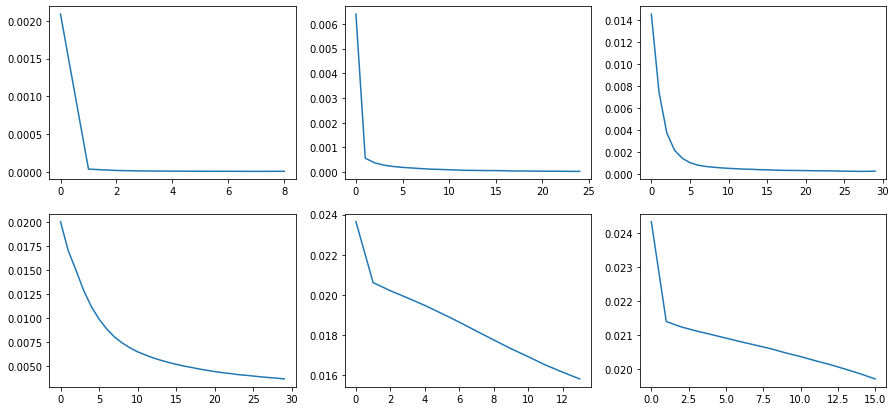

In [16]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].plot(losses2[0])
ax[0,1].plot(losses2[1])
ax[0,2].plot(losses2[2])
ax[1,0].plot(losses2[3])
ax[1,1].plot(losses2[4])
ax[1,2].plot(losses2[5])




#for i in ax.flatten():
    #i.set_ylim(0,0.01)

In [21]:
TEST_PREDS = [models[i](x_test[i].to('cuda')).detach() for i in range(len(models))]

In [23]:
Y_TEST=y_test
r2_losses = [r2_score(TEST_PREDS[i].cpu().detach(), Y_TEST[i].detach()) for i in range(len(TEST_PREDS))]

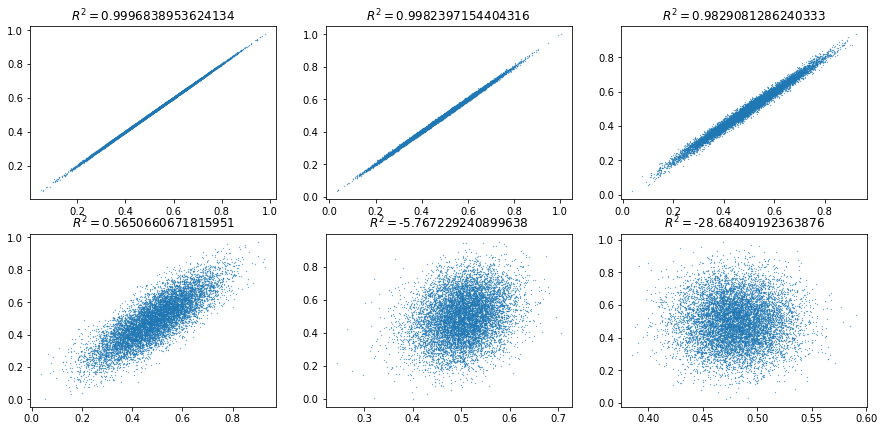

In [25]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].scatter(TEST_PREDS[0].cpu(), Y_TEST[0],marker='.', s=.3)
ax[0,1].scatter(TEST_PREDS[1].cpu(), Y_TEST[1],marker='.', s=.3)
ax[0,2].scatter(TEST_PREDS[2].cpu(), Y_TEST[2],marker='.', s=.3)
ax[1,0].scatter(TEST_PREDS[3].cpu(), Y_TEST[3],marker='.', s=.3)
ax[1,1].scatter(TEST_PREDS[4].cpu(), Y_TEST[4],marker='.', s=.3)
ax[1,2].scatter(TEST_PREDS[5].cpu(), Y_TEST[5],marker='.', s=.3)



for ind, i in enumerate(ax.flatten()):
    i.set_title("$R^2 = $" + str(r2_losses[ind]))
    


In [92]:
# Variable to store the output of the layer
layer_output = []

# Define a hook function to capture the output
def hook_fn(module, input, output):
    layer_outputs1.append(output)

# Register the hook to the conv1 layer
#hook = models[0].fc_layers[-1].register_forward_hook(hook_fn)




In [93]:
layer_outputs1 = [] 
hooks = [i.fc_layers[-1].register_forward_hook(hook_fn) for i in models]

In [94]:
landscapes_as_tensor = [torch.from_numpy(i).to(torch.float32) for i in landscapes_ohe]

In [95]:
model_forward_output = [models[i](landscapes_as_tensor[i].to('cuda')) for i in range(len(models))]

In [96]:
layer_outputs_np = [i.cpu().detach().numpy() for i in layer_outputs1]

In [1]:
len(layer_outputs1)

NameError: name 'layer_outputs1' is not defined

In [99]:
landscapes_flat = [i.reshape(i.shape[0], i.shape[1]*i.shape[2]) for i in landscapes_ohe]

In [100]:
from sklearn.neighbors import kneighbors_graph
import math
import networkx as nx
from scipy.sparse import diags

In [101]:
knn_k = int(math.sqrt(landscapes_flat[0].shape[0]))

In [102]:
knn_landscapes = [kneighbors_graph(landscapes_flat[i], n_neighbors=knn_k, n_jobs=-1) for i in range(len(landscapes_flat))]

In [103]:
knn_mlp_layers = [kneighbors_graph(layer_outputs_np[i], n_neighbors=knn_k, n_jobs=-1) for i in range(len(layer_outputs_np))]

In [104]:
landscape_y = [i.fitnesses.reshape(-1,1) for i in LANDSCAPES]

In [115]:
def adjacency_to_diag_laplacian(A): 
    """
    Calculates degree and laplacian matrices from an adjacency matrix.  
    
    Args: 
        A (scipy sparse matrix): adjacency of graph
    Returns: 
        D (scipy sparse matrix): degree matrix of graph
        L (scipy sparse matrix) : laplacian matrix of graph
    """
    degrees = A.sum(axis=1).A1
    D = diags(degrees, format='csr')
    L = D-A

    
    return D, L

def sparse_dirichlet(L, f): 
    """
    Calculates the Dirichlet energy of a signal f over a graph. 
    
    Args: 
    L (scipy sparse matrix): graph laplacian
    f (np array): signal over graph
    """

    f = f.astype('float64') 
    Lf  = L.dot(f)
    f_T = f.T
    fLf = f_T.dot(Lf)
    return fLf.item()
    

In [106]:
knn_landscapes_laplacians = [adjacency_to_diag_laplacian(i)[-1] for i in knn_landscapes]
knn_ml_layers_laplacians = [adjacency_to_diag_laplacian(i)[-1] for i in knn_mlp_layers]

In [107]:
len(knn_ml_layers_laplacians)

6

In [108]:
len(knn_landscapes_laplacians)

6

In [116]:
knn_landscapes_dirichlets = [sparse_dirichlet(knn_landscapes_laplacians[i], landscape_y[i]) for i in range(len(knn_landscapes_laplacians))]
knn_ml_layers_dirichlets = [sparse_dirichlet(knn_ml_layers_laplacians[i], landscape_y[i]) for i in range(len(knn_ml_layers_laplacians))]
   
    

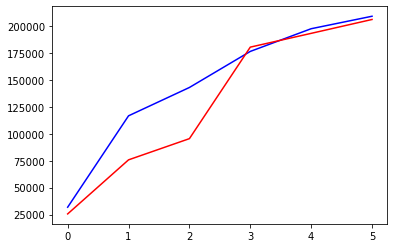

In [119]:
plt.plot(knn_landscapes_dirichlets, color='b')
plt.plot(knn_ml_layers_dirichlets, color='r')